# Significance VS Generalizability

Goal of this notebook is to show, with experiments on to (controlled) distributions of rankings, how significance and generalizability are distinct concepts. 
The intuition for this notebook can be summarized in two ways. 
The first, that significance is the property of one sample, while generalizability is the property of a distribution. 
The second, that significance is a property of a sample, while generalizabilit has to do with how well experimental results approximate the true distribution. 

Concretely, consider the following setup. 

We are comparing $n_a = 5$ alternatives on 20 experimental conditions. As detailed in the paper, Section 3.2, this is essentially equivalent to sampling from some distribution $\mathbb P$ with support $S_5$, the set of permutations of $5$ alternatives, i.e., rankings without ties. 
The resarch question we are trying to answer is always the following: ``Is there an alternative that is better than the others? ''
Current recommendations are Friedmann tests followed by Conover-Iman posthoc comparisons.  

Concretely, we will use the following distribution:
\begin{align}
   \mathbb P_1: &(01234) \mapsto 0.55\\
   &(10234) \mapsto 0.45.
\end{align}

In [1]:
import numpy as np
import pandas as pd

from scikit_posthocs import posthoc_conover_friedman
from scipy.stats import friedmanchisquare
from tqdm.auto import tqdm

from genexpy import random 
from genexpy import kernels as ku
from genexpy.utils import rankings as ru

na = 5  # number of alternatives
n = 20  # sample size
nrep = 1000  # number of samples

pval = 0.05  # pvalue for the tests
delta = 0.05  # similarity threshold for the rankings
kernel = ku.rankings.JaccardKernel(k=1)  # kernel for generalizability

## Significantly-best does not mean always-best

With this distribution, we show that, even when, within a sample, an alternative is significantly better than the others, it does not mean that the better alternative is always the same one. 

In [2]:
r0 = np.array([0, 1, 2, 3, 4])
r1 = np.array([1, 0, 2, 3, 4])
base_rm = np.stack(55*[r0] + 45*[r1], axis=1)
base_sample = ru.SampleAM.from_rank_vector_matrix(base_rm)
distr1 = random.PMFDistribution.from_sample(base_sample)

distr1.support, distr1.pmf

(SampleAM([b'\x01\x01\x01\x01\x01\x00\x01\x01\x01\x01\x00\x00\x01\x01\x01\x00\x00\x00\x01\x01\x00\x00\x00\x00\x01',
           b'\x01\x00\x01\x01\x01\x01\x01\x01\x01\x01\x00\x00\x01\x01\x01\x00\x00\x00\x01\x01\x00\x00\x00\x00\x01'],
          dtype='|S25'),
 array([0.55, 0.45]))

In [3]:
out = []
for _ in tqdm(list(range(nrep))):
    
    # --- Sample
    sample = distr1.sample(n=n)
    rank_matrix = sample.to_rank_vector_matrix()
    
    # get best alternatives (most times rank(alternative)==0)
    best = np.where((rank_matrix == 0).sum(axis=1) == (rank_matrix == 0).sum(axis=1).max())[0]
    
    # --- Tests
    # Friedman
    pval_friedman = friedmanchisquare(*rank_matrix)[1]
    sig_friedman = (pval_friedman <= pval)
    
    # if Friedman is significant, proceeed with Conover-Iman
    if sig_friedman:
        pval_conoveriman = posthoc_conover_friedman(rank_matrix.T)
        # C-I is significant if the best alternatives are significantly better than anything else
        sig_conoveriman = (posthoc_conover_friedman(rank_matrix.T).values[best] < pval).sum() == na - len(best)
    else:
        sig_conoveriman = False
    
    # --- Generalizability
    # compute generalizability for n // 2
    mmd = kernel.mmd_distribution(sample=sample, n=n//2, rep=200, method="embedding", replace=False, disjoint=True)
    generalizability = np.mean(mmd <= kernel.get_eps(delta, na=na))
    
    out.append(dict(
        na=na, 
        n=n,
        pval=pval, 
        distr=str(distr1),
        sig_friedman=sig_friedman,
        sig_conoveriman=sig_conoveriman,
        best=tuple(best), 
        generalizability=generalizability
    ))
out = pd.DataFrame(out)

  0%|          | 0/1000 [00:00<?, ?it/s]

We now proceed by filtering the significant results and checking their corresponding best alternatives.

In [6]:
sig_f = out.query("sig_friedman")
sig_ci = out.query("sig_conoveriman")
sig_not = out.query("not sig_conoveriman")

if len(sig_f) > 0:
    print(f"F-Significant: {len(sig_f)} / {len(out)} = {len(sig_f) / len(out)}")
    print(f"CI-Significant: {len(sig_ci)} / {len(out)} = {len(sig_ci) / len(out)}")
    print(f"Distribution of significantly best alternatives: \n{sig_ci.groupby('best')['best'].count()}")
else:
    print("No significant tests.")
    
print(f"Average generalizability: {out['generalizability'].mean():.3f} ({out['generalizability'].std():.3f})")
print(f"Average generalizability on significant samples: {sig_ci['generalizability'].mean():.3f} ({sig_ci['generalizability'].std():.3f})")
print(f"Average generalizability on non-significant samples: {sig_not['generalizability'].mean():.3f} ({sig_not['generalizability'].std():.3f})")

F-Significant: 1000 / 1000 = 1.0
CI-Significant: 333 / 1000 = 0.333
Distribution of significantly best alternatives: 
best
(0,)    276
(1,)     57
Name: best, dtype: int64
Average generalizability: 0.741 (0.103)
Average generalizability on significant samples: 0.737 (0.104)
Average generalizability on non-significant samples: 0.743 (0.102)


And now a more complete analysis also including the best alternatives. 

In [77]:
out.groupby(["sig_conoveriman", "best"])["generalizability"].agg(["count", "mean", "std"])

count      mean       std
sig_conoveriman best                             
False           (0,)      335  0.726060  0.104785
                (0, 1)    150  0.824233  0.025295
                (1,)      182  0.707253  0.101689
True            (0,)      276  0.740580  0.106332
                (1,)       57  0.718684  0.089660

Finally, let's compare the distribution of generalizability for significant, non-significant, and all samples.

In [102]:
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt

from pathlib import Path

figures_path = Path("figures")
figures_path.mkdir(exist_ok=True)

sns.set(style="ticks", context="paper", font="times new roman")

mpl.rcParams['text.usetex'] = True
mpl.rcParams['text.latex.preamble'] = r"""
\usepackage{mathptmx}
\usepackage{amsmath}
"""
mpl.rc('font', family='Times New Roman')

pretty_columns = dict(sig_conoveriman="C-I-Significant", 
                      generalizability="$10$-Gen", 
                      best=r"$a_{\text{best}}$")

boxplot_args = dict(
    showfliers=False, palette="cubehelix",
    dodge=True, native_scale=False, fill=False, width=0.75, boxprops={"linewidth": 1.2}, gap=0.25
)

In [92]:
from typing import Any

def _convert_item(item: Any) -> Any:
    """
    Convert a single element:
      * np.int64 → int
      * tuple/list/… → same container with all np.int64 converted
      * everything else → returned unchanged
    """
    # 1️⃣ scalar numpy integer
    if isinstance(item, np.integer):
        # np.integer is the parent of np.int64, np.int32, …
        return int(item)

    # 2️⃣ iterable containers (tuple, list, set, …) – we only need to
    #    handle the case you described (tuple), but supporting the others
    #    makes the helper more generally useful.
    if isinstance(item, (list, tuple, set)):
        # Preserve the original container type
        converted = (_convert_item(i) for i in item)  # generator → lazy conversion
        if isinstance(item, list):
            return list(converted)
        if isinstance(item, tuple):
            return tuple(converted)
        if isinstance(item, set):
            return set(converted)

    # 3️⃣ any other type – just return it as‑is
    return item

def convert_best_column(df: pd.DataFrame, column: str = "best") -> pd.DataFrame:
    """
    Return a *copy* of ``df`` where every ``np.int64`` occurring in
    ``df[column]`` (either as a scalar or inside a tuple) is turned into a
    native Python ``int``.

    Parameters
    ----------
    df : pd.DataFrame
        Input DataFrame.
    column : str, default "best"
        Name of the column to clean.

    Returns
    -------
    pd.DataFrame
        A copy of the original DataFrame with the cleaned column.
    """
    if column not in df.columns:
        raise KeyError(f"Column '{column}' not found in the DataFrame.")

    # Work on a shallow copy – the original DataFrame stays untouched.
    out = df.copy()

    # ``apply`` is the most readable way for a column that may contain
    # heterogeneous objects (scalars, tuples, …).  It also respects pandas'
    # index alignment.
    out[column] = out[column].apply(_convert_item)

    return out

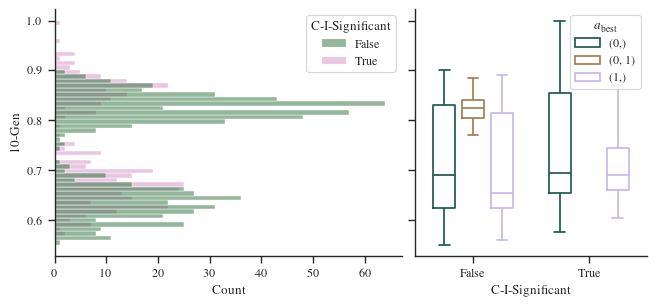

In [110]:
dfplot = out.copy()
dfplot = convert_best_column(dfplot, column="best")
dfplot = dfplot.rename(columns=pretty_columns)

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(6.5, 3), width_ratios=[6, 4], sharey="all")
axes = axes.flatten()

ax = axes[0]
sns.histplot(dfplot, y=pretty_columns["generalizability"], hue=pretty_columns["sig_conoveriman"], ax=ax, palette="cubehelix", stat="count", bins=50, legend=True)

ax = axes[1]
sns.boxplot(dfplot, x=pretty_columns["sig_conoveriman"], y=pretty_columns["generalizability"], ax=ax, **boxplot_args, hue=pretty_columns["best"])

sns.despine(top=True, right=True)
plt.tight_layout(pad=0.5)

fig.savefig("generalizability_vs_significance.pdf")
plt.show()